In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
from torch.nn import BatchNorm1d
import torch.optim as optim
from torch.utils.data import Dataset
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_add_pool
from torch_geometric.data import DataLoader, Data
import copy
import time
from sklearn.model_selection import train_test_split
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.PDB.Polypeptide import three_to_one
import biotite.structure as struc
import biotite.structure.io as strucio
import biotite.database.rcsb as rcsb
from biotite.structure import filter_amino_acids
from tqdm.notebook import tqdm
import seaborn as sn
from torch_geometric.utils.convert import to_networkx
import networkx as nx
from sklearn.metrics import f1_score
import pickle
from sklearn.metrics import roc_curve, auc

In [2]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 123
args.test_size = 0.2
args.shuffle = True

np.random.seed(args.seed)
torch.manual_seed(args.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
H1_dict = {'A' : 0.62, 
           'C' : 0.29, 
           'D' : -0.9, 
           'E' : -0.74, 
           'F' : 1.19, 
           'G' : 0.48, 
           'H' : -0.4, 
           'I' : 1.38, 
           'K' : -1.5, 
           'L' : 1.06, 
           'M' : 0.64, 
           'N' : -0.78, 
           'P' : 0.12, 
           'Q' : -0.85, 
           'R' : -2.53, 
           'S' : -0.18, 
           'T' : -0.05, 
           'V' : 1.08, 
           'W' : 0.81, 
           'Y' : 0.26}

In [4]:
H2_dict = {'A' : -0.5, 
           'C' : -1, 
           'D' : 3, 
           'E' : 3, 
           'F' : -2.5, 
           'G' : 0, 
           'H' : -0.5, 
           'I' : -1.8, 
           'K' : 3, 
           'L' : -1.8, 
           'M' : -1.3, 
           'N' : 2, 
           'P' : 0, 
           'Q' : 0.2, 
           'R' : 3, 
           'S' : 0.3, 
           'T' : -0.4, 
           'V' : -1.5, 
           'W' : -3.4, 
           'Y' : -2.3}

In [5]:
PL_dict = {'A' : 8.1, 
           'C' : 5.5, 
           'D' : 13, 
           'E' : 12.3, 
           'F' : 5.2, 
           'G' : 9, 
           'H' : 10.4, 
           'I' : 5.2, 
           'K' : 11.3, 
           'L' : 4.9, 
           'M' : 5.7, 
           'N' : 11.6, 
           'P' : 8, 
           'Q' : 10.5, 
           'R' : 10.5, 
           'S' : 9.2, 
           'T' : 8.6, 
           'V' : 5.9, 
           'W' : 5.4, 
           'Y' : 6.2}

In [6]:
SASA_dict = {'A' : 1.181, 
             'C' : 1.461, 
             'D' : 1.587, 
             'E' : 1.862, 
             'F' : 2.228, 
             'G' : 0.881, 
             'H' : 2.025, 
             'I' : 1.81, 
             'K' : 2.258, 
             'L' : 1.931, 
             'M' : 2.034, 
             'N' : 1.655, 
             'P' : 1.468, 
             'Q' : 1.932, 
             'R' : 2.56, 
             'S' : 1.298, 
             'T' : 1.525, 
             'V' : 1.645, 
             'W' : 2.663, 
             'Y' : 2.368}

In [7]:
pKa_dict = {'A' : 2.34,
            'R' : 2.17,
            'N' : 2.02,
            'D' : 1.88,
            'C' : 1.96,
            'E' : 2.19,
            'Q' : 2.17,
            'G' : 2.34,
            'H' : 1.82,
            'O' : 1.82,
            'I' : 2.36,
            'L' : 2.36,
            'K' : 2.18,
            'M' : 2.28,
            'F' : 1.83,
            'P' : 1.99,
            'U' : 0,
            'S' : 2.21,
            'T' : 2.09,
            'W' : 2.83,
            'Y' : 2.20,
            'V' : 2.32}

In [8]:
pKb_dict = {'A' : 9.69,
            'R' : 9.04,
            'N' : 8.80,
            'D' : 9.60,
            'C' : 10.28,
            'E' : 9.67,
            'Q' : 9.13,
            'G' : 9.60,
            'H' : 9.17,
            'O' : 9.65,
            'I' : 9.60,
            'L' : 9.60,
            'K' : 8.95,
            'M' : 9.21,
            'F' : 9.13,
            'P' : 10.60,
            'U' : 0,
            'S' : 9.15,
            'T' : 9.10,
            'W' : 9.39,
            'Y' : 9.11,
            'V' : 9.62}

In [9]:
pI_dict = {'A' : 6.00,
           'R' : 10.76,
           'N' : 5.41,
           'D' : 2.77,
           'C' : 5.07,
           'E' : 3.22,
           'Q' : 5.65,
           'G' : 5.97,
           'H' : 7.59,
           'O' : 0,
           'I' : 6.02,
           'L' : 5.98,
           'K' : 9.74,
           'M' : 5.74,
           'F' : 5.48,
           'P' : 6.30,
           'U' : 5.68,
           'S' : 5.68,
           'T' : 5.60,
           'W' : 5.89,
           'Y' : 5.66,
           'V' : 5.96}

In [10]:
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

AA = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
def aa_features(x):
    return np.array(one_of_k_encoding(x, AA) + 
                    one_of_k_encoding(int(ProteinAnalysis(x).aromaticity()), [0, 1]) +  
                    one_of_k_encoding(int(ProteinAnalysis(x).isoelectric_point()), [4, 5, 6, 8, 9]) + 
                    one_of_k_encoding(int(ProteinAnalysis(x).gravy()), [0, 1, 2, 3, 4, -4, -3, -1]) + 
                    one_of_k_encoding(int(ProteinAnalysis(x).secondary_structure_fraction()[0]), [0, 1]) + 
                    one_of_k_encoding(int(ProteinAnalysis(x).secondary_structure_fraction()[1]), [0, 1]) + 
                    one_of_k_encoding(int(ProteinAnalysis(x).secondary_structure_fraction()[2]), [0, 1]) + 
                    one_of_k_encoding(int(ProteinAnalysis(x).molar_extinction_coefficient()[0]), [0, 1490, 5500]) + 
                    one_of_k_encoding(int(ProteinAnalysis(x).molar_extinction_coefficient()[1]), [0, 1490, 5500]) + 
                    one_of_k_encoding(int(ProteinAnalysis(x).molecular_weight()), [121, 131, 132, 165, 133, 105, 75, 204, 174, 
                                                                                   146, 115, 147, 149, 117, 119, 181, 89, 155]) + 
                    one_of_k_encoding(H1_dict[x], list(set(list(H1_dict.values())))) + 
                    one_of_k_encoding(H2_dict[x], list(set(list(H2_dict.values())))) + 
                    one_of_k_encoding(PL_dict[x], list(set(list(PL_dict.values())))) + 
                    one_of_k_encoding(SASA_dict[x], list(set(list(SASA_dict.values())))) + 
                    one_of_k_encoding(pKa_dict[x], list(set(list(pKa_dict.values())))) + 
                    one_of_k_encoding(pKb_dict[x], list(set(list(pKb_dict.values())))) + 
                    one_of_k_encoding(pI_dict[x], list(set(list(pI_dict.values())))))

def adjacency2edgeindex(adjacency):
    start = []
    end = []
    adjacency = adjacency - np.eye(adjacency.shape[0], dtype=int)
    for x in range(adjacency.shape[1]):
        for y in range(adjacency.shape[0]):
            if adjacency[x, y] == 1:
                start.append(x)
                end.append(y)

    edge_index = np.asarray([start, end])
    return edge_index

AMINOS =  ['CYS', 'ASP', 'SER', 'GLN', 'LYS', 'ILE', 'PRO', 'THR', 'PHE', 'ASN', 
           'GLY', 'HIS', 'LEU', 'ARG', 'TRP', 'ALA', 'VAL', 'GLU', 'TYR', 'MET']
def filter_20_amino_acids(array):
    return ( np.in1d(array.res_name, AMINOS) & (array.res_id != -1) )

# RNA Graph (1Q8N) 
# filter_20_amino_acids -> filter_seq
SEQ = ['A', 'T', 'G', 'C', 'U']
def filter_seq(array):
    return ( np.in1d(array.res_name, SEQ) & (array.res_id != -1) )

def protein_analysis(pdb_id):
    file_name = rcsb.fetch(pdb_id, "mmtf", './data/pdb')
    array = strucio.load_structure(file_name)
#     protein_mask = filter_amino_acids(array)
    protein_mask = filter_20_amino_acids(array)
    try:
        array = array[protein_mask]
    except:
        array = array[0]
        array = array[protein_mask]
    try:
        ca = array[array.atom_name == "CA"]
    except:
        array = array[0]
        ca = array[array.atom_name == "CA"]
    
    seq = ''.join([three_to_one(str(i).split(' CA')[0][-3:]) for i in ca])
    # 7 Angstrom adjacency threshold
    threshold = 7
    # Create cell list of the CA atom array
    # for efficient measurement of adjacency
    cell_list = struc.CellList(ca, cell_size=threshold)
    A = cell_list.create_adjacency_matrix(threshold)
    A = np.where(A == True, 1, A)

    return [aa_features(aa) for aa in seq], adjacency2edgeindex(A)

def pro2vec(pdb_id):
    node_f, edge_index = protein_analysis(pdb_id)
    data = Data(x=torch.tensor(node_f, dtype=torch.float),
                edge_index=torch.tensor(edge_index, dtype=torch.long))
    print(data)
    return data

def make_pro(df):
    pro1_key = []
    pro2_key = []
    pro_value = []
    for i in range(df.shape[0]):
        pro1_key.append(df['Protein_1'].iloc[i])
        pro2_key.append(df['Protein_2'].iloc[i])
        pro_value.append(df['PPI'].iloc[i])
    return pro1_key, pro2_key, pro_value

def save_graph(graph_path, pdb_id):
    vec = pro2vec(pdb_id)
    np.save(graph_path+pdb_id+'_e.npy', vec.edge_index)
    np.save(graph_path+pdb_id+'_n.npy', vec.x)
    
def load_graph(graph_path, pdb_id):
    n = np.load(graph_path+pdb_id+'_n.npy')
    e = np.load(graph_path+pdb_id+'_e.npy')
    N = torch.tensor(n, dtype=torch.float)
    E = torch.tensor(e, dtype=torch.long)
    data = Data(x=N, edge_index=E)
    return data

def make_vec(pro1, pro2, value):
    X1 = []
    X2 = []
    Y = []
    for i in range(len(pro1)):
        m1 = pro1[i]
        m2 = pro2[i]
        y = value[i]
        try:
            v1 = load_graph('./data/graph/', m1)
            v2 = load_graph('./data/graph/', m2)
            if v1.x.shape[0] < 100000:
                if v2.x.shape[0] < 100000:
                    X1.append(v1)
                    X2.append(v2)
                    Y.append(y)
        except:
            continue
    for i, data in enumerate(X1):
        y = Y[i]
        data.y = torch.tensor([y], dtype=torch.long)
    for i, data in enumerate(X2):
        y = Y[i]
        data.y = torch.tensor([y], dtype=torch.long)
    return X1, X2

def df_check(df):
    df['pro2vec'] = 'Yes'
    for i in range(df.shape[0]):
        try:
            save_graph('./data/graph/', df['Protein_1'].iloc[i])
            save_graph('./data/graph/', df['Protein_2'].iloc[i])
        except:
            df['pro2vec'].iloc[i] = 'No'
            continue
    df = df[df['pro2vec'] != 'No'].reset_index(drop=True)
    del df['pro2vec']
    return df

Data(edge_index=[2, 2408], x=[313, 194])


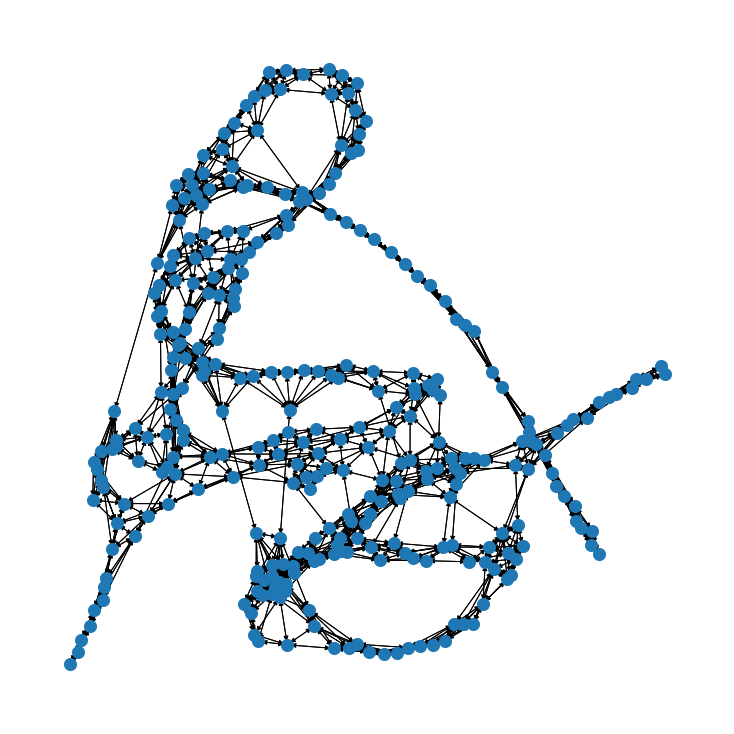

In [11]:
# Example
graph = pro2vec('3ETU')
G = to_networkx(graph)
plt.figure(1,figsize=(10, 10)) 
nx.draw(G, node_size=50,linewidths=6)
plt.show()

#### Dataset
https://github.com/baranwa2/Struct2Graph/blob/master/interactions_data.txt

In [12]:
# df = pd.read_csv('./interactions_data.txt', sep='\t', header=None)
# df.columns = ['Protein_1', 'Protein_2', 'PPI']
# df = df_check(df) # Save Graphs
# df.to_excel('./ProGraph_PPI_DB.xlsx', index=False)
df = pd.read_excel('./ProGraph_PPI_DB.xlsx')
df

,Protein_1,Protein_2,PPI
0,3BLV,4BSZ,0
1,3ETU,3JCK,0
2,3C66,2QRJ,0
3,1S4U,1S2M,0
4,6BGT,2V76,1
...,...,...,...
11127,1WQL,1WQL,1
11128,6FAI,1I3Q,0
11129,2LCS,4BSZ,0
11130,5A63,2KLC,1


In [13]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=2021, stratify=df['PPI'])
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
len(X_train), len(X_test)

(8905, 2227)

In [14]:
train_pro1_key, train_pro2_key, train_pro_value = make_pro(X_train)
test_pro1_key, test_pro2_key, test_pro_value = make_pro(X_test)

In [15]:
train_X1, train_X2 = make_vec(train_pro1_key, train_pro2_key, train_pro_value)
test_X1, test_X2 = make_vec(test_pro1_key, test_pro2_key, test_pro_value)
len(train_X1), len(train_X2), len(test_X1), len(test_X2)

(8905, 8905, 2227, 2227)

In [16]:
train_X = []
for i in range(len(train_X1)):
    train_X.append([train_X1[i], train_X2[i]])
test_X = []
for i in range(len(test_X1)):
    test_X.append([test_X1[i], test_X2[i]])

print('- Train Data :', len(train_X))
print('- Test Data :', len(test_X))

- Train Data : 8905
- Test Data : 2227


In [17]:
class GCNlayer(nn.Module):
    def __init__(self, n_features, conv_dim1, conv_dim2, conv_dim3, concat_dim, dropout):
        super(GCNlayer, self).__init__()
        self.n_features = n_features
        self.conv_dim1 = conv_dim1
        self.conv_dim2 = conv_dim2
        self.conv_dim3 = conv_dim3
        self.concat_dim =  concat_dim
        self.dropout = dropout
        
        self.conv1 = GCNConv(self.n_features, self.conv_dim1, cached=False)
        nn.init.xavier_uniform_(self.conv1.weight)
        self.bn1 = BatchNorm1d(self.conv_dim1)
        self.conv2 = GCNConv(self.conv_dim1, self.conv_dim2, cached=False)
        nn.init.xavier_uniform_(self.conv2.weight)
        self.bn2 = BatchNorm1d(self.conv_dim2)
        self.conv3 = GCNConv(self.conv_dim2, self.conv_dim3, cached=False)
        nn.init.xavier_uniform_(self.conv3.weight)
        self.bn3 = BatchNorm1d(self.conv_dim3)
        self.conv4 = GCNConv(self.conv_dim3, self.concat_dim, cached=False)
        nn.init.xavier_uniform_(self.conv4.weight)
        self.bn4 = BatchNorm1d(self.concat_dim)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = global_add_pool(x, data.batch)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x
    
class FClayer(nn.Module):
    def __init__(self, concat_dim, pred_dim1, pred_dim2, pred_dim3, out_dim, dropout):
        super(FClayer, self).__init__()
        self.concat_dim = concat_dim
        self.pred_dim1 = pred_dim1
        self.pred_dim2 = pred_dim2
        self.pred_dim3 = pred_dim3
        self.out_dim = out_dim
        self.dropout = dropout

        self.fc1 = Linear(self.concat_dim*2, self.pred_dim1)
        self.bn1 = BatchNorm1d(self.pred_dim1)
        self.fc2 = Linear(self.pred_dim1, self.pred_dim2)
        self.bn2 = BatchNorm1d(self.pred_dim2)
        self.fc3 = Linear(self.pred_dim2, self.pred_dim3)
        self.fc4 = Linear(self.pred_dim3, self.out_dim)
    
    def forward(self, data):
        x = F.relu(self.fc1(data))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc4(x)
        return x
    
class Net(nn.Module):
    def __init__(self, args):
        super(Net, self).__init__()
        self.conv1 = GCNlayer(args.n_features, 
                              args.conv_dim1, 
                              args.conv_dim2, 
                              args.conv_dim3, 
                              args.concat_dim, 
                              args.dropout)
        
        self.conv2 = GCNlayer(args.n_features, 
                              args.conv_dim1, 
                              args.conv_dim2, 
                              args.conv_dim3, 
                              args.concat_dim, 
                              args.dropout)

        self.fc = FClayer(args.concat_dim, 
                          args.pred_dim1, 
                          args.pred_dim2, 
                          args.pred_dim3, 
                          args.out_dim, 
                          args.dropout)
        
    def forward(self, pro1, pro2):
        x1 = self.conv1(pro1)
        x2 = self.conv2(pro2)
        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1) # Regression과 다름
        return x

In [18]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
import pickle
from sklearn.metrics import roc_curve, auc


def save_checkpoint(epoch, model, optimizer, filename):
    state = {
        'Epoch': epoch,
        'State_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, filename)

def train(model, device, optimizer, train_loader, criterion, args):
    train_correct = 0
    train_total = 0
    epoch_train_loss = 0
    for i, [solute, solvent] in enumerate(train_loader):
        solute = solute.to(device)
        solvent = solvent.to(device)
        labels = solute.y.to(device)
        optimizer.zero_grad()
        outputs = model(solute, solvent)
        outputs.require_grad = False
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_train_loss /= len(train_loader)
    train_acc =  100 * train_correct / train_total
    print('- Loss : %.4f' % epoch_train_loss)
    print('- Accuracy : %.4f' % train_acc)
    return model, epoch_train_loss, train_acc


def test(model, device, test_loader, args):
    model.eval()
    classes = ('0', '1')
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    correct = 0
    total = 0
    nb_classes = len(classes)
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    test_hist = {"test_acc":[]}
    y_score =[]
    y_test =[]
    logS_total = []
    pred_logS_total = []
    roc_total = dict()
    with torch.no_grad():
        for i, [solute, solvent] in enumerate(test_loader):
            solute = solute.to(device)
            solvent = solvent.to(device)
            labels = solute.y.to(device)
            logS_total += solute.y.tolist()
            outputs = model(solute, solvent)
            pred_logS_total += outputs.view(-1).tolist()
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            y_score.append(outputs.cpu().numpy())
            y_test.append(labels.cpu().numpy())
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            for i in range(labels.shape[0]):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_hist["test_acc"].append((predicted == labels).sum().item())
                
    # ROC Curve
    y_test_list = []
    for i in y_test[0]:
        t_list = [0, 0, 0]
        t_list[i] = 1
        y_test_list.append(t_list)
    roc = dict()
    roc['name'] = str(args.exp_name)
    roc['y_score'] = y_score[0].tolist()
    roc['y_test'] = y_test_list
    roc_total[str(args.exp_name)] = roc
    # save data
#     with open('PPI.pickle','wb') as fw:
#         pickle.dump(roc_total, fw)

    logS_total = list(labels.view(-1).cpu().numpy())
    pred_logS_total = list(predicted.view(-1).cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_score][0]
    conf = confusion_matrix.tolist()
    total_acc = 100 * correct / total
    low = 100 * class_correct[0] / class_total[0]
    medium = 100 * class_correct[1] / class_total[1]
    miscore = f1_score(logS_total, pred_logS_total, average='micro')
    mascore = f1_score(logS_total, pred_logS_total, average='macro')
    print()
    print('[Test]')
    print('- Total Accuracy : %d %%' % (100 * correct / total))            
    print('- Accuracy of 0 : %2d %%' % (low))
    print('- Accuracy of 1 : %2d %%' % (medium))
    print('- F-1 Micro Score : %.2f' % (float(miscore)))
    print('- F-1 Macro Score : %.2f' % (float(mascore)))
    return conf, total_acc, low, medium, miscore, mascore, logS_total, pred_logS_total, y_pred_list


def experiment(model, train_loader, test_loader, device, args):
    time_start = time.time()
    
    optimizer = optim.Adam(model.parameters(),lr=args.lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step_size,
                                          gamma=args.gamma)
    
    list_train_loss = list()
    list_train_acc = list()
    print('[Train]')
    for epoch in range(args.epoch):
        scheduler.step()
        print('- Epoch :', epoch+1)
        model, train_loss, train_acc = train(model, device, optimizer, train_loader, criterion, args)
        list_train_loss.append(train_loss)
        list_train_acc.append(train_acc)
    
    conf, total_acc, low, medium, miscore, mascore, logS_total, pred_logS_total, y_pred_list = test(model, device, test_loader, args)
    
    time_end = time.time()
    time_required = time_end - time_start
    
    args.list_train_loss = list_train_loss
    args.list_train_acc = list_train_acc
    args.logS_total = logS_total
    args.pred_logS_total = pred_logS_total
    args.conf = conf
    args.total_acc = total_acc
    args.low = low
    args.medium = medium
    args.miscore = miscore
    args.mascore = mascore
    args.time_required = time_required
    args.y_pred_list = y_pred_list
    
    save_checkpoint(epoch, model, optimizer, './mymodel.pt')
    
    return args

In [19]:
args.batch_size = 32
args.epoch = 100
args.lr = 0.00001
args.optim = 'Adam'
args.step_size = 10
args.gamma = 0.9
args.dropout = 0.1
args.n_features = 194
args.conv_dim1 = 128
args.conv_dim2 = 128
args.conv_dim3 = 128
args.concat_dim = 128
args.pred_dim1 = 128
args.pred_dim2 = 128
args.pred_dim3 = 128
args.out_dim = 2

model = Net(args)
model = model.to(device)

train_loader = DataLoader(train_X, batch_size=args.batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_X, batch_size=args.batch_size, shuffle=False, drop_last=True)

dict_result = dict()
args.exp_name = 'Test'
result = vars(experiment(model, train_loader, test_loader, device, args))
dict_result[args.exp_name] = copy.deepcopy(result)
torch.cuda.empty_cache()

result_df = pd.DataFrame(dict_result).transpose()
result_df.to_json('PPI.JSON', orient='table')

[Train]
- Epoch : 1


/home/mhlee/anaconda3/envs/mhlee/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


- Loss : 0.6369
- Accuracy : 64.1637
- Epoch : 2
- Loss : 0.5457
- Accuracy : 78.8444
- Epoch : 3
- Loss : 0.4747
- Accuracy : 82.2842
- Epoch : 4
- Loss : 0.4309
- Accuracy : 82.9249
- Epoch : 5
- Loss : 0.3880
- Accuracy : 85.0719
- Epoch : 6
- Loss : 0.3536
- Accuracy : 86.6682
- Epoch : 7
- Loss : 0.3271
- Accuracy : 87.7810
- Epoch : 8
- Loss : 0.2974
- Accuracy : 88.9726
- Epoch : 9
- Loss : 0.2781
- Accuracy : 89.8494
- Epoch : 10
- Loss : 0.2593
- Accuracy : 91.0634
- Epoch : 11
- Loss : 0.2371
- Accuracy : 91.8615
- Epoch : 12
- Loss : 0.2233
- Accuracy : 92.0863
- Epoch : 13
- Loss : 0.2074
- Accuracy : 92.7046
- Epoch : 14
- Loss : 0.1972
- Accuracy : 93.1992
- Epoch : 15
- Loss : 0.1883
- Accuracy : 93.5814
- Epoch : 16
- Loss : 0.1765
- Accuracy : 93.9861
- Epoch : 17
- Loss : 0.1623
- Accuracy : 94.9191
- Epoch : 18
- Loss : 0.1574
- Accuracy : 94.6830
- Epoch : 19
- Loss : 0.1502
- Accuracy : 94.9078
- Epoch : 20
- Loss : 0.1435
- Accuracy : 95.4024
- Epoch : 21
- Loss :

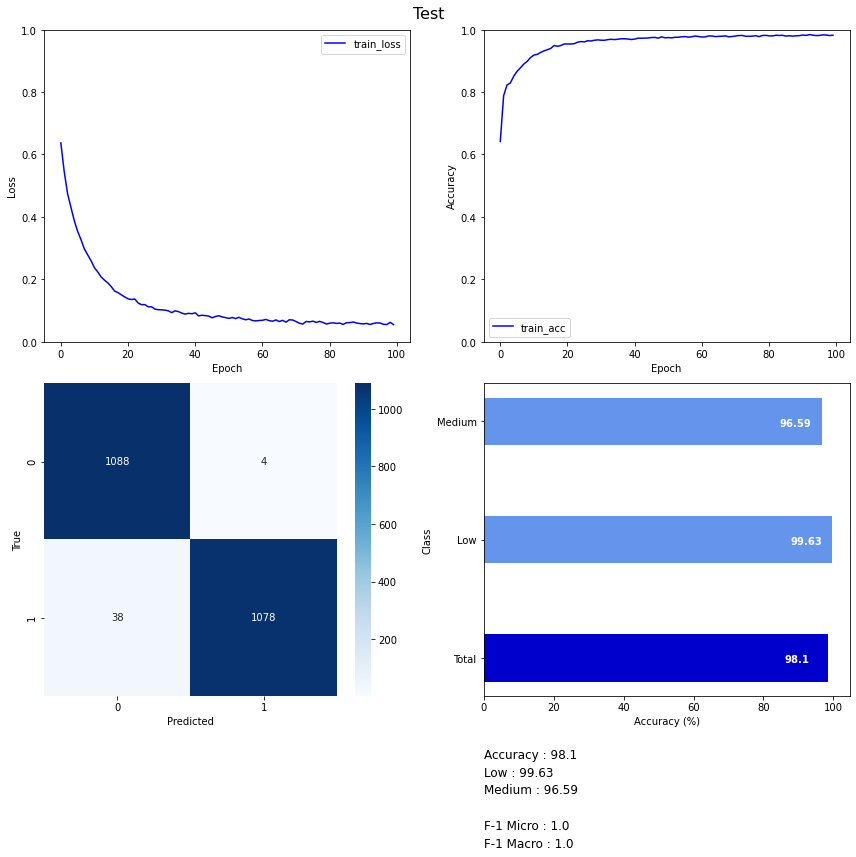

In [20]:
classes = ('0', '1')
df = pd.read_json('PPI.JSON', orient='table')
plt.rcParams["figure.figsize"] = (12, 12)
plt.suptitle(args.exp_name, fontsize=16)

train_loss = df['list_train_loss'].iloc[0]
train_acc = df['list_train_acc'].iloc[0]
c = df['conf'].iloc[0]
confusion_matrix = np.array([c[0], c[1]], dtype=float)
df_cm = pd.DataFrame(confusion_matrix, range(len(classes)), range(len(classes)))
accuracy = df['total_acc'].iloc[0]
accuracy_1 = df['low'].iloc[0]
accuracy_2 = df['medium'].iloc[0]
acc_list = [accuracy, accuracy_1, accuracy_2]
y_true = df['logS_total'].iloc[0]
y_pred = df['pred_logS_total'].iloc[0]
miscore = df['miscore'].iloc[0]
mascore = df['mascore'].iloc[0]
plt.subplot(2, 2, 1)
plt.ylim([0, 1])
plt.plot([e for e in range(len(train_loss))], [float(t) for t in train_loss], label="train_loss", c='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(2, 2, 2)
plt.ylim([0, 1])
plt.plot([e for e in range(len(train_acc))], [float(t)*0.01 for t in train_acc], label="train_acc", c='blue')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(2, 2, 3)
sn.heatmap(df_cm.astype('int'), annot=True, cmap='Blues', fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.subplot(2, 2, 4)
plt.xlabel('Accuracy (%)')
plt.ylabel("Class")
barlist = plt.barh(['Total', 'Low', 'Medium'], acc_list, height=0.4, color='cornflowerblue')
barlist[0].set_color('mediumblue')
for i, v in enumerate(acc_list):
    plt.text(v-12, i-0.04, str(round(v,2)), color='white', fontweight='bold')
acc1_test = 'Accuracy : ' + str(round(float(accuracy), 2))
acc2_test = 'Low : ' + str(round(float(accuracy_1), 2))
acc3_test = 'Medium : ' + str(round(float(accuracy_2), 2))
mi_test = 'F-1 Micro : ' + str(round(float(miscore), 2))
ma_test = 'F-1 Macro : ' + str(round(float(mascore), 2))
plt.text(0, -0.85, acc1_test, fontsize=12)
plt.text(0, -1.00, acc2_test, fontsize=12)
plt.text(0, -1.15, acc3_test, fontsize=12)
plt.text(0, -1.45, mi_test, fontsize=12)
plt.text(0, -1.6, ma_test, fontsize=12)
plt.tight_layout()
plt.savefig('PPI.png')
plt.show()